In [497]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/corelibs/src/tools-python"))
sys.path.append(os.path.expanduser("/workspace/code/corelibs/build/datatypes"))
sys.path.append(os.path.expanduser("/workspace/code/corelibs/build/datatypes/datatypes_python"))

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

In [498]:
# Open monolithic and iterate frames
dataset_path = "/workspace/data/pose-prediction-odometry/"
RO_relative_poses_path = dataset_path+"ro_relative_poses.monolithic"
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])
print("Finished reading",len(RO_timestamps),"poses.")

reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 479 poses.


In [499]:
# # dim1_data = np.zeros(len(RO_timestamps))
# dim1_data = np.zeros(400)

# for i in range(len(dim1_data)):
#     dim1_data[i] = RO_se3s[i][0,3]

In [500]:
num_features = 1
num_frames = 2
input_size = num_features * num_frames
output_size = num_features

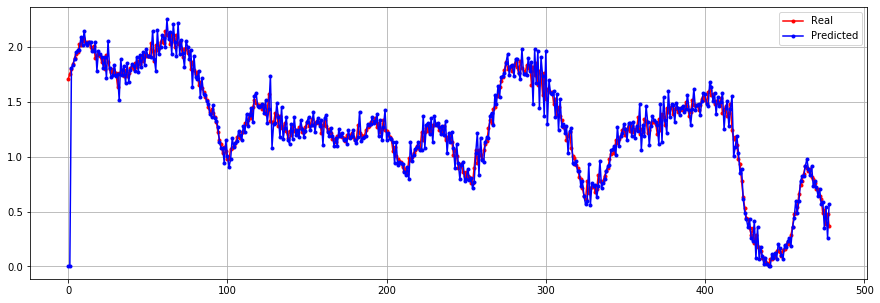

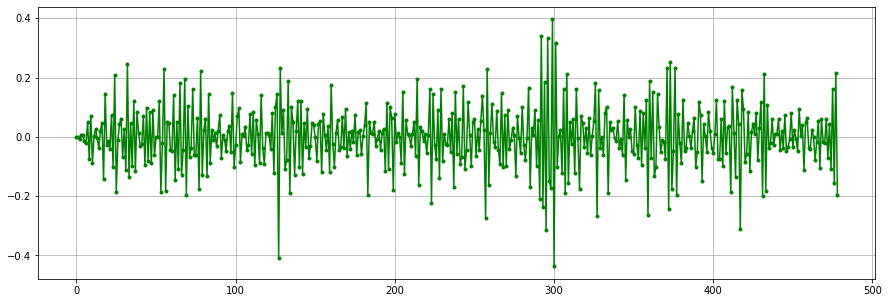

In [511]:
use_toy_data = False
tx_data = np.zeros(479)

# tx_pred = np.zeros(len(tx_data)-2)

for i in range(len(tx_data)):
    tx_data[i] = RO_se3s[i][0,3]

if(use_toy_data):
    # Creating the artificial dataset
    tx_data = np.arange(0,10,0.1)

    # adding noise
    for i in range(len(tx_data)):
        tx_data[i] += np.sin(i) + np.random.randn()*0.001

tx_pred = np.zeros(len(tx_data))
tx_model_err = np.zeros(len(tx_data))
        
for i in range(2,len(tx_pred)):
    tx_pred[i] = tx_data[i-1] + (tx_data[i-1] - tx_data[i-2])
    tx_model_err[i] = tx_data[i] - tx_pred[i]
        
plt.figure(figsize=(15,5))
plt.plot(tx_data,'r.-')
plt.plot(tx_pred,'b.-')
plt.legend(["Real","Predicted"])
plt.grid()

plt.figure(figsize=(15,5))
plt.plot(tx_model_err,'g.-')
plt.grid()

dim1_data = tx_model_err # hack to allow the rest of the code to remain the same

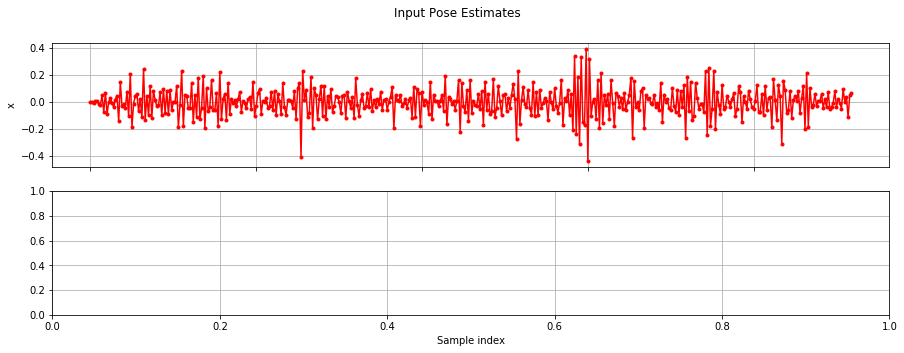

In [502]:
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()

# Plot subfigures
fig,axs = plt.subplots(2,figsize=(15,5))
fig.suptitle('Input Pose Estimates')
axs[0].plot(dim1_data,'r.-')
axs[0].set(ylabel = 'x')

for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [503]:
# For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
# [x1,y1,th1,x2,y2,th2]
# These are offset, so that x1 goes up until the second last frame
# (current frame is treated as future prediction)

# output tensor holds single frame, for x, y, and theta values
# This is cropped to exclude the first n frames (n=2 here) and run up until the end
# So a synthesised 'future' value to aim for

t_x = torch.tensor(dim1_data_scaled)

x_data = torch.zeros(len(dim1_data)-num_frames,input_size)
start_idx = 0
end_idx = len(x_data)
frame_idx = num_frames - 1

for i in range(num_frames):
    x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
    start_idx+=1
    end_idx+=1
    frame_idx-=1 # older frames are assigned to later columns
    
y_data = torch.zeros(len(dim1_data)-num_frames,output_size)
y_data[:,0] = t_x[num_frames:]

In [504]:
x_rows = x_data.size()[0]
train_validate_ratio = 0.8
training_idx_limit = int(train_validate_ratio * x_rows)

x_train = x_data[:training_idx_limit,:]
x_valid = x_data[training_idx_limit:,:]

y_train = y_data[:training_idx_limit,:]
y_valid = y_data[training_idx_limit:,:]

print('x_data dimensions:',x_data.size())
print('x_train dimensions:',x_train.size())
print('x_valid dimensions:',x_valid.size())
print('y_data dimensions:',y_data.size())
print('y_train dimensions:',y_train.size())
print('y_valid dimensions:',y_valid.size())

x_data dimensions: torch.Size([458, 2])
x_train dimensions: torch.Size([366, 2])
x_valid dimensions: torch.Size([92, 2])
y_data dimensions: torch.Size([458, 1])
y_train dimensions: torch.Size([366, 1])
y_valid dimensions: torch.Size([92, 1])


In [505]:
class Pose_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)
    
epochs = 10
lr = 0.1
batch_size = 10

model = Pose_Logistic()
criterion = nn.MSELoss()
Loss = []  # variable for storing losses after each epoch

train_ds = TensorDataset(x_train,y_train)
valid_ds = TensorDataset(x_valid,y_valid)

def loss_batch(model,loss_func,xb,yb,opt=None):
    loss=loss_func(model(xb),yb)
    
    if opt is not None:
        Loss.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(),len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def get_model():
    model = Pose_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [506]:
loss_func = criterion

train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4013923458431078
1 0.38562077283859253
2 0.4227036056311234
3 0.38704514373903687
4 0.4287999745296395
5 0.41761892904406006
6 0.5130779464607653
7 0.442189642916555
8 0.43051433433657105
9 0.4151795953512192


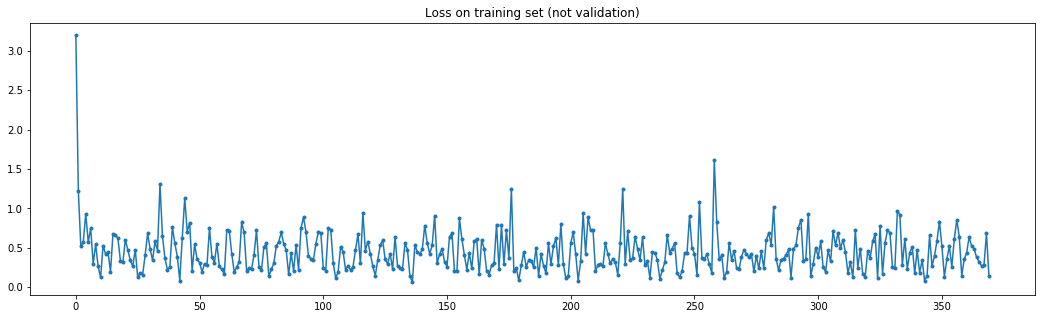

In [507]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set (not validation)")
plt.plot(Loss,'.-')

In [508]:
# query_dim1 = np.array([3.2,3.1])
# query_dim2 = np.array([0.032,0.031]) #np.array([0.32,0.31])
# query_dim3 = np.array([0.032,0.031])

# Prediction frame, just for sanity checking (not proper testing)
idx = 40
query_dim1 = np.array([dim1_data[idx-1],dim1_data[idx-2]])

# query_dim1 = np.array([dim1_data[idx-1],dim1_data[idx-2],dim1_data[idx-3]])

print(query_dim1)

scaled_query_dim1 = (query_dim1 - dim1_data.mean())/dim1_data.std()

# Build combination so x, y, and theta are adjacent for 1 pose
c = np.empty(scaled_query_dim1.size)
c[0::num_features] = scaled_query_dim1

new_query = Variable(torch.Tensor([c]))
print(new_query)

answer = model(new_query)
print('\n raw answer:\n',answer)
print('\n scaled up again:')
print((answer[0][0]*dim1_data.std() + dim1_data.mean()).data)
print('True answer:',dim1_data[idx])

[0.01453248 0.08278102]
tensor([[0.1337, 0.7682]])

 raw answer:
 tensor([[-0.4902]], grad_fn=<AddmmBackward>)

 scaled up again:
tensor(-0.0526)
True answer: -0.031243423830769723


(0, 100)

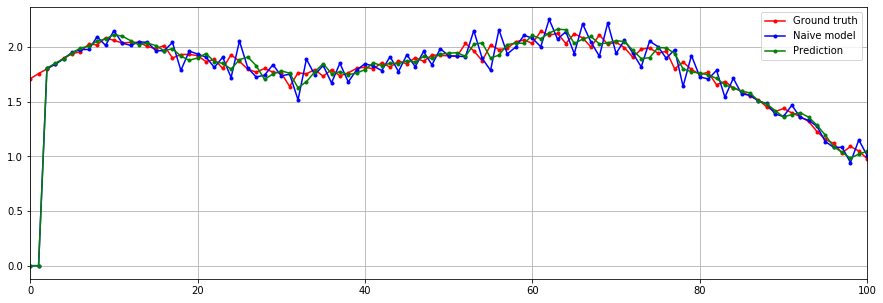

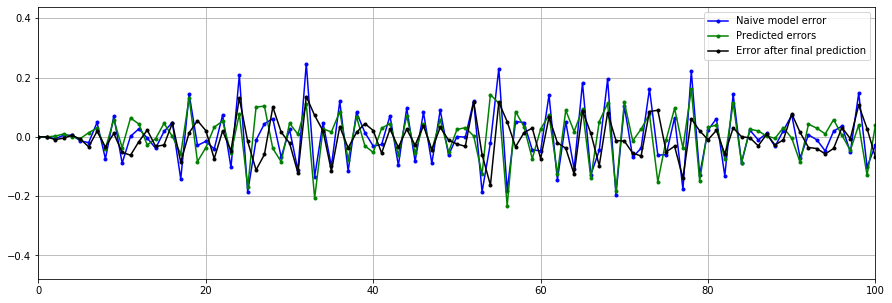

In [509]:
predictions = np.zeros(len(tx_data))
predicted_errors = np.zeros(len(tx_data))
final_err = np.zeros(len(tx_data))

for i in range(2,len(predictions)):
    query_dim1 = np.array([dim1_data[i-1],dim1_data[i-2]])
#     query_dim1 = np.array([dim1_data[i-1],dim1_data[i-2],dim1_data[idx-3]])
    scaled_query_dim1 = (query_dim1 - dim1_data.mean())/dim1_data.std()

    # Build combination so x, y, and theta are adjacent for 1 pose
    c = np.empty(scaled_query_dim1.size)
    c[0::num_features] = scaled_query_dim1

    new_query = Variable(torch.Tensor([c]))

    answer = model(new_query)
    predicted_errors[i] = (answer[0][0]*dim1_data.std() + dim1_data.mean()).data
    predictions[i] =  tx_data[i-1] + (tx_data[i-1] - tx_data[i-2]) + predicted_errors[i] #tx_model_err[i]
    final_err[i] = tx_data[i] - predictions[i]
    
plt.figure(figsize=(15,5))
plt.plot(tx_data,'r.-',label='Ground truth')
plt.plot(tx_pred,'b.-',label='Naive model')
plt.plot(predictions,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

plt.figure(figsize=(15,5))
plt.plot(tx_model_err,'b.-',label='Naive model error')
plt.plot(predicted_errors,'g.-',label='Predicted errors')
plt.plot(final_err,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

In [510]:
# Only read results after predictor has kicked in (so from 3rd frame onwards)
print(np.mean(np.abs(tx_model_err[3:])))
print(np.mean(np.abs(predicted_errors[3:])))
print(np.mean(np.abs(final_err[3:])))

0.081912825639295
0.06785419857396548
0.05290501258877253
